In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path = "C:\\Users\\30448\\Documents\\Kaggle\\265"
df = pd.read_csv( path + "\\accidents.csv" )
print "The dataset has %d rows and %d columns" % (df.shape[0] , df.shape[1])
df.head()

The dataset has 36314 rows and 10 columns


,wkt_geom,code,severity,time,lat,desc,lon,name,clust,NN
0,POINT(6119950.59451242536306381 1886366.970110...,201,2,04/10/13 08:00 AM,37.165655,Accident and recovery work on Bear Creek Road ...,-122.015948,Accident(s),31,11
1,POINT(6163265.98209197819232941 2195198.763392...,201,2,04/10/13 05:30 PM,38.015568,CA-4 exit ramp partially blocked due to accide...,-121.882976,Accident(s),14,3
2,POINT(6156011.13359668850898743 2064637.280291...,201,3,04/10/13 05:55 PM,37.656750,I-680 Southbound exit ramp partially blocked d...,-121.901370,Accident(s),11,52
3,POINT(6040154.25608104187995195 2127971.038348...,201,3,04/10/13 06:17 PM,37.825210,Right hand shoulder blocked due to accident on...,-122.305740,Accident(s),28,11
4,POINT(6160755.65850416570901871 2058394.601888...,243,3,04/10/13 06:19 PM,37.639801,Lane blocked due to accident on I-680 Southbou...,-121.884663,Accident. Left lane blocked,11,51


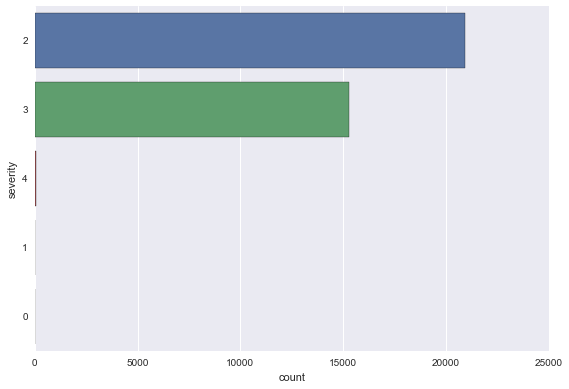

In [2]:
sns.countplot(y = "severity" , data = df )
plt.tight_layout()

In [3]:
pd.DataFrame( {"count": df["severity"].value_counts().values } , index = df["severity"].value_counts().index )

,count
2,20944
3,15296
4,54
1,19
0,1


<b> The dataset is very unbalanced so we remove the rows with severity = 0 , 1 or 4 </b>

In [4]:
df = df.loc[df["severity"] >  1].loc[df["severity"] < 4]

<b> Pre-Processing the time features: creating months, weekday year and hour features </b>

In [5]:
df["month"] = df["time"].apply(lambda x:int(x[:2]))
df["day"] = df["time"].apply(lambda x:int(x[3:5]))
df["year"] = df["time"].apply(lambda x:int(x[6:8]))
df["hour"] =  df["time"].apply(lambda x: int(x[9:11]) if str(x)[15] == 'A' else 12 + int(x[9:11])  )
df["lon"] = df["lon"].apply(lambda x:abs(x)) #so that multinomialNB works (only with positive features)
#creating the date at the datetime format (easier to deal with)
df[ "date" ]= df[["month" , "day" ,"year"]].apply(lambda x:pd.datetime(month = x['month'] , day = x['day']  , year = 2000+x["year"]), axis = 1)
df["weekday"] =  df["date"].apply(lambda x:x.weekday())

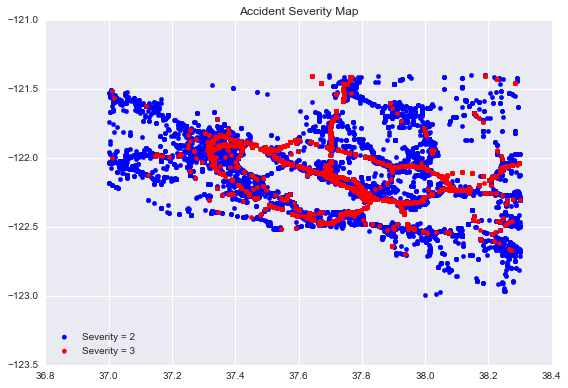

In [6]:
#plotting the dataset with a different color depending on the severity
df2 = df.loc[df["severity"] == 2]
df3 = df.loc[df["severity"] == 3]

xx2 , yy2 = df2["lat"] , -df2["lon"]
xx3 , yy3 = df3["lat"] , -df3["lon"]

pts2 = plt.scatter(xx2,yy2,color = 'b' )
pts3 = plt.scatter(xx3,yy3,color = 'r' )
plt.legend((pts2, pts3), ('Severity = 2', 'Severity = 3'),loc='lower left')
plt.title("Accident Severity Map")
plt.tight_layout()

<b> Univariate Analysis </b>

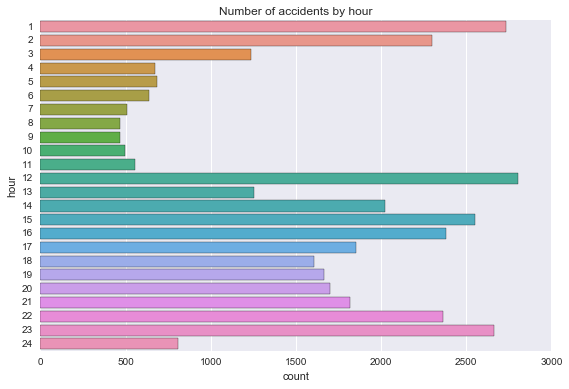

In [7]:
sns.countplot(y = "hour" , data = df , order = range(1,25))
plt.title("Number of accidents by hour")
plt.tight_layout()

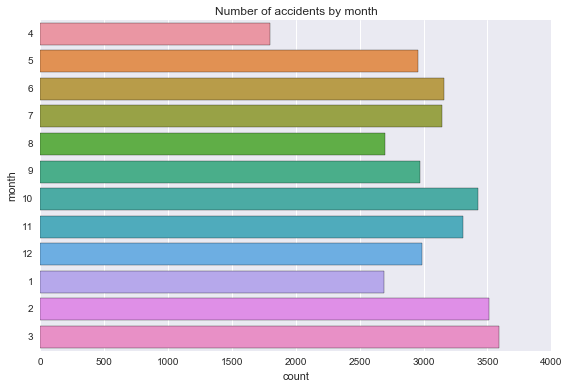

In [8]:
sns.countplot(y = "month" , data = df)
plt.title("Number of accidents by month")
plt.tight_layout()

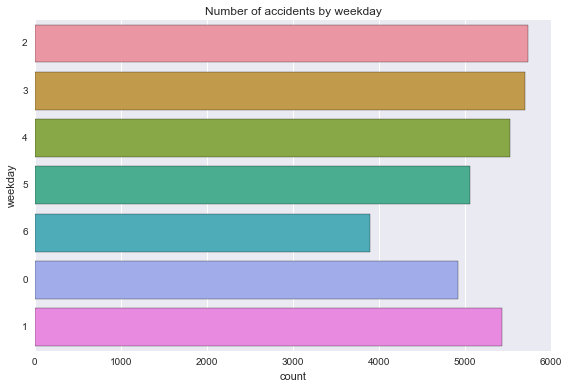

In [9]:
sns.countplot(y = "weekday" , data = df)
plt.title("Number of accidents by weekday")
plt.tight_layout()

In [10]:
severity_by_hour = pd.crosstab(index = df["hour"] , columns = df["severity"] )
severity_by_hour = pd.DataFrame(severity_by_hour.values)
severity_by_hour["ratio"] = severity_by_hour.apply(lambda x:x[0]/float(x[1]) , axis = 1)
severity_by_hour.sort_values(by = "ratio")

,0,1,ratio
22,1363,1301,1.047656
0,1402,1329,1.054929
11,1447,1355,1.067897
12,656,596,1.100671
21,1300,1061,1.225259
23,452,358,1.262570
1,1283,1015,1.264039
13,1132,892,1.269058
20,1040,778,1.336761
14,1494,1060,1.409434


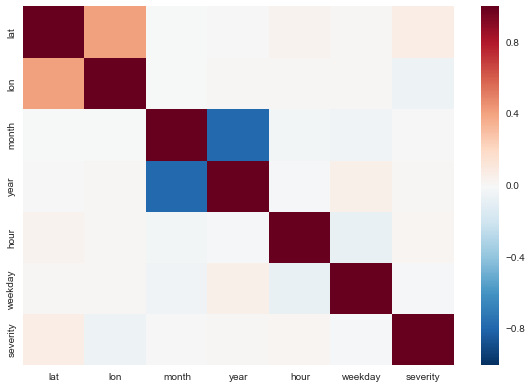

In [11]:
df_corr = df[["lat" , "lon" , "month" , "year" , "hour" , "weekday" , "severity"]]
correlation = df_corr.corr()
sns.heatmap(correlation)
plt.tight_layout()

In [30]:
X = df[["month" , "hour" , "year", "weekday" ,"lon" , "lat"]]
y = df["severity"].apply(lambda x:x-2)

from sklearn.cross_validation import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 

In [31]:
from sklearn.metrics import *
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
def printScores(y_test, y_pred, classif_name):    
    print "--------------  "  + classif_name + "  ------------------"  
    print "recall : %0.2f" %  recall_score(y_test, y_pred) 
    print "precision : %0.2f" %  precision_score(y_test, y_pred)   
    print "f1 : %0.2f" %  f1_score(y_test, y_pred)  
    print "accuracy : %0.2f" %  accuracy_score(y_test, y_pred)  
    print "---------------------------------------------------"  

In [47]:
sev = y.value_counts()
pd.DataFrame(sev)

,severity
0,20944
1,15296


In [48]:
print "worst accuracy: " , max(sev)/float(sum(sev))

worst accuracy:  0.577924944812


In [32]:
#logreg 
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train,y_train)
y_pred = pd.Series(clf.predict(X_test))
printScores(y_test, y_pred, "LogisticRegression")

--------------  LogisticRegression  ------------------
recall : 0.05
precision : 0.26
f1 : 0.08
accuracy : 0.54
---------------------------------------------------


In [33]:
#multinomial NB
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
printScores(y_test, y_pred, "MultinomialNB")   

--------------  MultinomialNB  ------------------
recall : 0.00
precision : 0.00
f1 : 0.00
accuracy : 0.58
---------------------------------------------------


In [34]:
#knn 
from sklearn.neighbors import KNeighborsClassifier
for nb in [1,3,7]:
    print "nb neighbors: %d" %nb    
    clf = KNeighborsClassifier(n_neighbors=nb)
    clf.fit(X_train,y_train)
    y_pred = pd.Series(clf.predict(X_test))
    printScores(y_test, y_pred, "KNeighborsClassifier")

nb neighbors: 1
--------------  KNeighborsClassifier  ------------------
recall : 0.64
precision : 0.59
f1 : 0.62
accuracy : 0.66
---------------------------------------------------
nb neighbors: 3
--------------  KNeighborsClassifier  ------------------
recall : 0.60
precision : 0.54
f1 : 0.57
accuracy : 0.62
---------------------------------------------------
nb neighbors: 7
--------------  KNeighborsClassifier  ------------------
recall : 0.54
precision : 0.51
f1 : 0.52
accuracy : 0.59
---------------------------------------------------


In [35]:
#tree
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
printScores(y_test, y_pred, "tree")

--------------  tree  ------------------
recall : 0.91
precision : 0.90
f1 : 0.91
accuracy : 0.92
---------------------------------------------------


<b> What are the most important features? </b>

In [36]:
pd.DataFrame(100*clf.feature_importances_ , index = X_train.columns)

,0
month,3.806011
hour,5.115286
year,0.300812
weekday,2.927446
lon,45.159810
lat,42.690634


<p>The position features (lat and lon) are undoubtedly the most important.</p>
On the other hand year doesn't provide much information.'

In [54]:
#tree
X_train2 , X_test2 = X_train[["lat" , "lon" ]]  , X_test[["lat" , "lon" ]]
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train2,y_train)
y_pred = clf.predict(X_test2)
printScores(y_test, y_pred, "tree")

--------------  tree  ------------------
recall : 0.96
precision : 0.92
f1 : 0.94
accuracy : 0.95
---------------------------------------------------


In [55]:
#random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train2,y_train)
y_pred = clf.predict(X_test2)
printScores(y_test, y_pred, "RandomForestClassifier")

--------------  RandomForestClassifier  ------------------
recall : 0.96
precision : 0.92
f1 : 0.94
accuracy : 0.95
---------------------------------------------------


In [42]:
#SVM
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train2, y_train)  
y_pred = clf.predict(X_test2)
printScores(y_test, y_pred, "svm")

--------------  svm  ------------------
recall : 0.70
precision : 0.67
f1 : 0.69
accuracy : 0.73
---------------------------------------------------


In [49]:
#SVM linear
from sklearn import svm
clf = svm.SVC(kernel = "linear")
clf.fit(X_train2, y_train)  
y_pred = clf.predict(X_test2)
printScores(y_test, y_pred, "linear svm")

--------------  linear svm  ------------------
recall : 0.00
precision : 0.00
f1 : 0.00
accuracy : 0.58
---------------------------------------------------


In [50]:
#logreg 
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train2,y_train)
y_pred = pd.Series(clf.predict(X_test2))
printScores(y_test, y_pred, "LogisticRegression")

--------------  LogisticRegression  ------------------
recall : 0.04
precision : 0.28
f1 : 0.07
accuracy : 0.55
---------------------------------------------------


In [51]:
#multinomial NB 
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train2,y_train)
y_pred = clf.predict(X_test2)
printScores(y_test, y_pred, "MultinomialNB")   

--------------  MultinomialNB  ------------------
recall : 0.00
precision : 0.00
f1 : 0.00
accuracy : 0.58
---------------------------------------------------


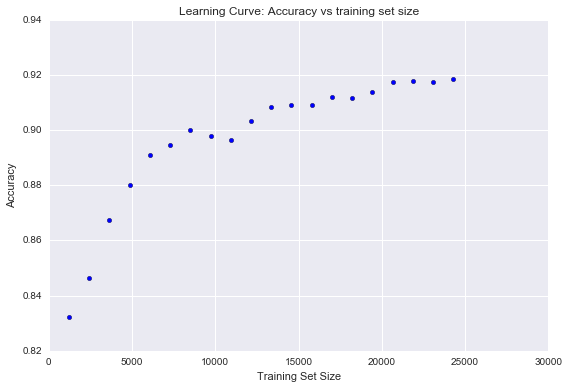

In [26]:
training_set_size = [0.05*i for i in range(1,21)]
accuracy = []
from sklearn import tree   
for size in training_set_size:
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=1-size, random_state=42) 
    clf = tree.DecisionTreeClassifier()  
    clf.fit(X_train2,y_train2)
    y_pred = clf.predict(X_test)
    accuracy.append(  (X_train2.shape[0] ,accuracy_score(y_test, y_pred) )  )

xx = [w[0] for w in accuracy]
yy = [w[1] for w in accuracy]
plt.scatter(xx,yy)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title("Learning Curve: Accuracy vs training set size")
plt.tight_layout()